In [1]:
import pandas as pd 
import numpy as np
import openpyxl
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)

In [2]:
metro = pd.read_csv('eco2mix-metropoles-tr.csv', sep=';')
mfdata = pd.read_csv('meteo-france-donneesq-covid19.csv', sep =';', encoding = 'latin1', on_bad_lines='skip')
dpe = pd.read_excel('DPE.xlsx')

C:\Users\alexi\AppData\Local\Temp\ipykernel_16540\992950685.py:1: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  metro = pd.read_csv('eco2mix-metropoles-tr.csv', sep=';')


# Météo France : MFDATA

In [3]:
mfdata['Date'] = pd.to_datetime(mfdata['DATE'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
mfdata.drop(columns=['DATE', 'POSTE', 'POSTE', 'LON', 'LAT', 'ALT', 'QRR', 'QTN', 'QTX', 'QTM', 'QFFM', 'QUN', 'QUX', 
                         'QDHUMI40', 'QDHUMI80', 'QUM'], inplace=True)                      

In [4]:
mfdata = mfdata.rename(columns={'RR' : 'Precipitation', 
                                      'TN' : 'Temperature_minimale',
                                      'TX' : 'Temperature_maximale', 
                                      'TM' : 'Temperature_moyenne',
                                      'FFM' : 'Moyenne_du_vent_a_10m', 
                                      'UN' : 'Humidite_relative_minimale',
                                      'UX' : 'Humidite_relative_maximale',
                                      'DHUMI40' : 'Duree_humidite_inf_a_40_pct', 
                                      'DHUMI80' : 'Duree_humidite_sup_a_80_pct',
                                      'UM' : 'Humidite_moyenne',
                                      'NOM' : 'Ville'})

# Consommation par métropole : METRO

In [5]:
metro['Ville']=''
metro.loc[metro['Métropole'] == 'Clermont Auvergne Métropole', 'Ville'] = 'CLERMONT-FD'
metro.loc[metro['Métropole'] == "Métropole d'Aix-Marseille-Provence", 'Ville'] = 'MARSEILLE'
metro.loc[metro['Métropole'] == 'Métropole de Lyon', 'Ville'] = 'LYON-BRON'
metro.loc[metro['Métropole'] == 'Dijon Métropole', 'Ville'] = 'DIJON-LONGVIC'
metro.loc[metro['Métropole'] == 'Métropole Grenoble-Alpes-Métropole', 'Ville'] = 'GRENOBLE-ST GEOIRS'
metro.loc[metro['Métropole'] == 'Métropole Européenne de Lille', 'Ville'] = 'LILLE-LESQUIN'
metro.loc[metro['Métropole'] == 'Métropole du Grand Nancy', 'Ville'] = 'NANCY-ESSEY'
metro.loc[metro['Métropole'] == 'Montpellier Méditerranée Métropole', 'Ville'] = 'MONTPELLIER-AEROPORT'
metro.loc[metro['Métropole'] == 'Nantes Métropole', 'Ville'] = 'NANTES-BOUGUENAIS' #Non
metro.loc[metro['Métropole'] == 'Bordeaux Métropole', 'Ville'] = 'BORDEAUX-MERIGNAC' #Non
metro.loc[metro['Métropole'] == 'Brest Métropole', 'Ville'] = 'BREST-GUIPAVAS' #Non
metro.loc[metro['Métropole'] == "Métropole Nice Côte d'Azur", 'Ville'] = 'NICE' #vérif si différent de marseilles et hyeres
metro.loc[metro['Métropole'] == "Métropole du Grand Paris", 'Ville'] = 'PARIS-MONTSOURIS'
metro.loc[metro['Métropole'] == "Eurométropole de Strasbourg", 'Ville'] = 'STRASBOURG-ENTZHEIM'
metro.loc[metro['Métropole'] == "Saint-Etienne Métropole", 'Ville'] = 'ST ETIENNE-BOUTHEON' #vérifier si différent de clermond
metro.loc[metro['Métropole'] == "Métropole Rennes Métropole", 'Ville'] = 'RENNES-ST JACQUES'#Non
metro.loc[metro['Métropole'] == "Métropole Rouen Normandie", 'Ville'] = 'ROUEN-BOOS'
metro.loc[metro['Métropole'] == "Métropole Toulon-Provence-Méditerranée", 'Ville'] = 'HYERES'#vérifier si différent de marseilles et nice
metro.loc[metro['Métropole'] == "Toulouse Métropole", 'Ville'] = 'TOULOUSE-BLAGNAC'
metro.loc[metro['Métropole'] == "Orléans Métropole", 'Ville'] = 'ORLEANS'
metro.loc[metro['Métropole'] == "Tours Métropole Val de Loire", 'Ville'] = 'TOURS'

#nom métropole = station météo

In [6]:
metro.dropna(subset='Consommation (MW)', inplace=True)

In [7]:
metro['Date'] = pd.to_datetime(metro['Date'])
metro_mean = metro.groupby(["Ville", pd.Grouper(key="Date", freq="D")]).agg({"Consommation (MW)": "mean"}).reset_index()

In [8]:
metro_mean['Date'] = metro_mean['Date'].dt.strftime('%Y-%m-%d') 
df = pd.merge(metro_mean, mfdata, on=['Date', 'Ville'], how='left')

# DATAVIZ

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [19]:
graph = df.copy() #df pour les graph

In [38]:
#Moyenne glissante
graph['Temperature_smooth'] = graph['Temperature_moyenne'].rolling(window=7).mean()
graph['consommation_smooth'] = graph['Consommation (MW)'].rolling(window=7).mean()
graph['vitesse_vent_smooth'] = graph['Moyenne_du_vent_a_10m'].rolling(window=7).mean()
graph['humidite_smooth'] = graph['Humidite_relative_maximale'].rolling(window=7).mean()

In [40]:
paris = graph[graph['Ville'] == 'PARIS-MONTSOURIS']

## Température

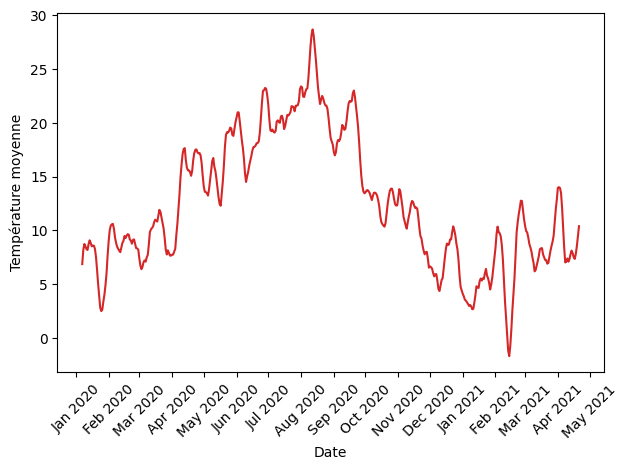

In [41]:
fig, ax = plt.subplots()

paris['Date'] = pd.to_datetime(paris['Date'], format='%Y-%m-%d')

ax.set_xlabel('Date')
ax.set_ylabel('Température moyenne')
ax.plot(paris['Date'], paris['Temperature_smooth'], color='tab:red')
ax.tick_params(axis='y')

ax.xaxis.set_major_locator(mdates.MonthLocator())  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()


## Consommation

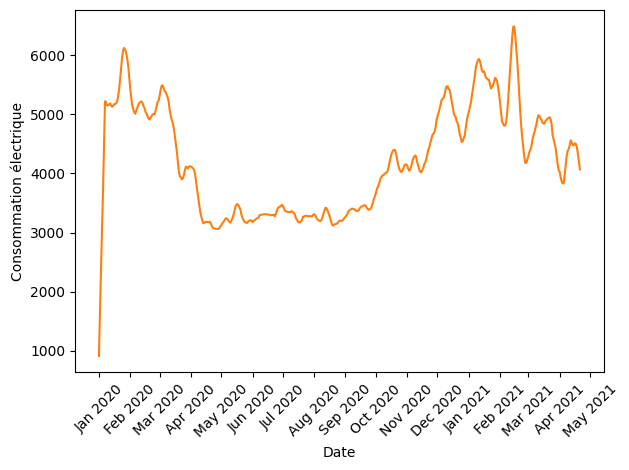

In [37]:
fig, ax1 = plt.subplots()

paris['Date'] = pd.to_datetime(paris['Date'], format='%Y-%m-%d')

ax1.set_xlabel('Date')
ax1.set_ylabel('Consommation électrique')
ax1.plot(paris['Date'], paris['consommation_smooth'], color='tab:orange')
ax1.tick_params(axis='y')

ax1.xaxis.set_major_locator(mdates.MonthLocator())  
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()


## Vent

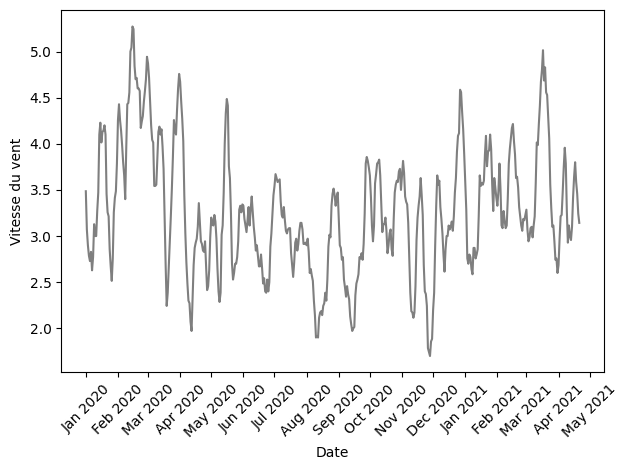

In [34]:
fig, ax2 = plt.subplots()

paris['Date'] = pd.to_datetime(paris['Date'], format='%Y-%m-%d')

ax2.set_xlabel('Date')

ax2.set_ylabel('Vitesse du vent')
ax2.plot(paris['Date'], paris['vitesse_vent_smooth'], color='tab:grey')
ax2.tick_params(axis='y')

ax2.xaxis.set_major_locator(mdates.MonthLocator())  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=45)  


plt.tight_layout()
plt.show()


## Humidité

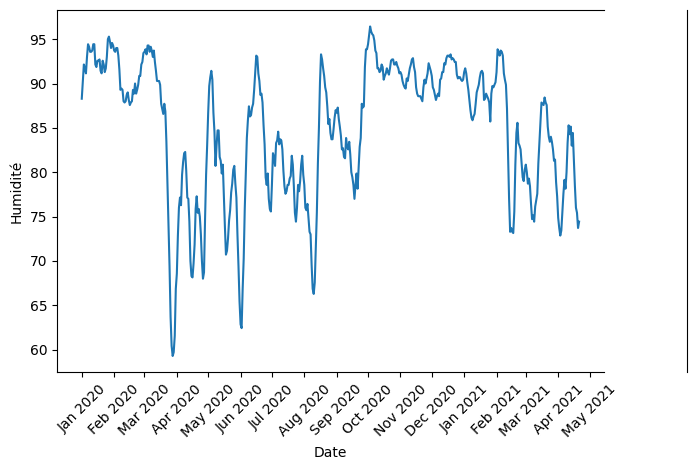

In [35]:
fig, ax3 = plt.subplots()

paris['Date'] = pd.to_datetime(paris['Date'], format='%Y-%m-%d')

ax3.set_xlabel('Date')

ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Humidité')
ax3.plot(paris['Date'], paris['humidite_smooth'], color='tab:blue')
ax3.tick_params(axis='y')


ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Préparation pour la régression

In [9]:
# Replace comma with period in the columns
df["Precipitation"] = df["Precipitation"].str.replace(",", ".").astype(float)
df["Temperature_minimale"] = df["Temperature_minimale"].str.replace(",", ".").astype(float)
df["Temperature_maximale"] = df["Temperature_maximale"].str.replace(",", ".").astype(float)
df["Temperature_moyenne"] = df["Temperature_moyenne"].str.replace(",", ".").astype(float)
df["Moyenne_du_vent_a_10m"] = df["Moyenne_du_vent_a_10m"].str.replace(",", ".").astype(float)

In [10]:
df.isnull().sum(axis = 0)/len(df)*100 #valeurs manquantes

Ville                          0.000000
Date                           0.000000
Consommation (MW)              0.000000
Precipitation                  0.000000
Temperature_minimale           0.000000
Temperature_maximale           0.000000
Temperature_moyenne            0.020229
Moyenne_du_vent_a_10m          0.343886
Humidite_relative_minimale     0.010114
Humidite_relative_maximale     0.010114
Duree_humidite_inf_a_40_pct    0.212400
Duree_humidite_sup_a_80_pct    0.222514
Humidite_moyenne               0.000000
dtype: float64

In [11]:
df.dropna(inplace=True)

In [12]:
cols = ['Precipitation',
       'Temperature_minimale', 'Temperature_maximale', 'Temperature_moyenne',
       'Moyenne_du_vent_a_10m', 'Humidite_relative_minimale',
       'Humidite_relative_maximale', 'Duree_humidite_inf_a_40_pct',
       'Duree_humidite_sup_a_80_pct', 'Humidite_moyenne']

Le F-test mesure le degré de dépendance linéaire entre les variables et la target via l'analyse de la variance (ANOVA). Il s'agit de comparer la variance de la target avec en la régressant sur les variables, à la variance de la target sans la régression.

In [14]:
#F-test : 
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
#selection with Ftest

X_fscore = df[cols].astype(float).values
y_fscore = df["Consommation (MW)"].astype(float).values

selector = SelectKBest(f_regression, k=2)
selector.fit(X_fscore, y_fscore)

# F-test scores of all the variables
scores = selector.scores_

# Sort the variables by their F-test scores
sorted_indices = np.argsort(scores)[::-1]
sorted_cols = [cols[i] for i in sorted_indices]
print("Le F-score des variables est :")

for col in sorted_cols:
    print(f"{col}: {scores[cols.index(col)]}")

Le F-score des variables est :
Humidite_relative_maximale: 153.92320503183745
Temperature_maximale: 109.71490662174033
Temperature_moyenne: 73.25026621247353
Moyenne_du_vent_a_10m: 72.38693329884752
Temperature_minimale: 13.751447988906051
Duree_humidite_sup_a_80_pct: 13.656740891348132
Humidite_moyenne: 9.048455213730026
Humidite_relative_minimale: 5.586829425322859
Precipitation: 0.00670069986456052
Duree_humidite_inf_a_40_pct: 0.0016681647662180011


Le RFE procède par itération en éliminant les variables les moins importantes (ici selon le R²), et chaque métrique avec le score le plus faible est éliminée 

In [15]:
#RFE score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

X_rfe = df[cols].astype(float).values
y_rfe = df["Consommation (MW)"].astype(float).values

# Initialize the model
model = LinearRegression()

# Initialize the RFECV object with the model and cross-validation parameters
selector = RFECV(estimator=model, step=1, cv=5, scoring='r2')

# Fit the RFECV object to the data
selector.fit(X_rfe, y_rfe)

# RFE ranking of the variables
ranks = selector.ranking_

# Sort the variables by their RFE ranking
sorted_indices = np.argsort(ranks)
sorted_cols = [cols[i] for i in sorted_indices]
print("Le classement RFE des variables est :")
for col in sorted_cols:
    print(f"{col}: {ranks[cols.index(col)]}")

#lowest RFE ranking is the most important variable

Le classement RFE des variables est :
Moyenne_du_vent_a_10m: 1
Temperature_maximale: 2
Temperature_minimale: 3
Humidite_relative_maximale: 4
Temperature_moyenne: 5
Precipitation: 6
Humidite_moyenne: 7
Humidite_relative_minimale: 8
Duree_humidite_inf_a_40_pct: 9
Duree_humidite_sup_a_80_pct: 10


# Régression préliminaire : Consommation sur DPE

## Données

In [16]:
df_aggregated = df.groupby(['Ville'])['Consommation (MW)'].sum().reset_index()
df_dpe = pd.merge(df_aggregated, dpe, on='Ville', how='left')

In [17]:
df_dpe['D-E'] = df_dpe['D'] + df_dpe['E']
df_dpe.rename(columns={"%F&G ensemble" : "F-G"}, inplace=True)
df_dpe.drop(columns=['D', 'E', 'F', 'G'], inplace=True)

## Score variables explicatives : F-test et RFE

In [18]:
cols = ['Nombre de DPE', 'A-B-C', 'Nombre de DPE F ou G', 'F-G', 'D-E']

#F-test : 
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np
#selection with Ftest

X_fscore = df_dpe[cols].astype(float).values
y_fscore = df_dpe["Consommation (MW)"].astype(float).values

selector = SelectKBest(f_regression, k=2)
selector.fit(X_fscore, y_fscore)

# F-test scores of all the variables
scores = selector.scores_

# Sort the variables by their F-test scores
sorted_indices = np.argsort(scores)[::-1]
sorted_cols = [cols[i] for i in sorted_indices]

print("Le F-score des variables est :")
for col in sorted_cols:
    print(f"{col}: {scores[cols.index(col)]}")

print("------------------------------")

#RFE score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

X_rfe = df_dpe[cols].astype(float).values
y_rfe = df_dpe["Consommation (MW)"].astype(float).values

# Initialize the model
model = LinearRegression()

# Initialize the RFECV object with the model and cross-validation parameters
selector = RFECV(estimator=model, step=1, cv=5, scoring='r2')

# Fit the RFECV object to the data
selector.fit(X_rfe, y_rfe)

# RFE ranking of the variables
ranks = selector.ranking_

# Sort the variables by their RFE ranking
sorted_indices = np.argsort(ranks)
sorted_cols = [cols[i] for i in sorted_indices]
print("Le classement RFE des variables est :")
for col in sorted_cols:
    print(f"{col}: {ranks[cols.index(col)]}")

#lowest RFE ranking is the most important variable

Le F-score des variables est :
Nombre de DPE: 175.15082818244815
Nombre de DPE F ou G: 170.45579656398348
F-G: 15.156146786048824
A-B-C: 1.9632730847982787
D-E: 1.1698612409989928
------------------------------
Le classement RFE des variables est :
A-B-C: 1
Nombre de DPE F ou G: 1
F-G: 1
D-E: 1
Nombre de DPE: 2


In [19]:
df_dpe = df_dpe.reindex(columns=['Ville', 'Consommation (MW)', 'A-B-C', 'D-E', 'F-G', 'Nombre de DPE F ou G', 'Nombre de DPE'])

## Régression avec le nombre de DPE

In [20]:
drop_dpe_ = ['Ville', 'Consommation (MW)', 'A-B-C', 'Nombre de DPE']

In [21]:
X_dpe = df_dpe.drop(drop_dpe_, axis=1).astype(float).values
y_dpe = df_dpe["Consommation (MW)"].astype(float).values

In [22]:
# Instancier le modèle de régression linéaire
_model = LinearRegression()

# Entraîner le modèle sur les données
_model.fit(X_dpe, y_dpe)

LinearRegression()

In [23]:
coefficients = pd.DataFrame(_model.coef_, df_dpe.drop(drop_dpe_, axis=1).columns, columns=["Coefficient"])
#drop_dpe = []

# Afficher les coefficients de régression pour chaque variable explicative
print(coefficients)

                       Coefficient
D-E                  -9.629552e+02
F-G                  -1.257715e+06
Nombre de DPE F ou G  2.562142e+02


In [24]:
# Afficher l'ordonnée à l'origine (intercept)
print("Intercept : ", _model.intercept_)

Intercept :  263552.19661443704


## Régression sans nombre de DPE

In [25]:
drop_dpe = ['Ville', 'Consommation (MW)', 'A-B-C']#, 'Nombre de DPE']

In [26]:
X_dpe = df_dpe.drop(drop_dpe, axis=1).astype(float).values
y_dpe = df_dpe["Consommation (MW)"].astype(float).values

In [27]:
# Instancier le modèle de régression linéaire
_model = LinearRegression()

# Entraîner le modèle sur les données
_model.fit(X_dpe, y_dpe)

LinearRegression()

In [28]:
coefficients = pd.DataFrame(_model.coef_, df_dpe.drop(drop_dpe, axis=1).columns, columns=["Coefficient"])
#drop_dpe = []

# Afficher les coefficients de régression pour chaque variable explicative
print(coefficients)

                        Coefficient
D-E                   125769.016504
F-G                   274533.525226
Nombre de DPE F ou G      91.834630
Nombre de DPE             51.917182


In [29]:
# Afficher l'ordonnée à l'origine (intercept)
print("Intercept : ", _model.intercept_)

Intercept :  -141987.400725284


# Régression totale

In [31]:
# Sélectionner les colonnes pour la régression linéaire
col_infos = df[['Date', 'Ville']]
drop_cols_tot = ['Consommation (MW)', 'Date', 'Ville']
X = df.drop(drop_cols_tot, axis=1).astype(float).values
y = df["Consommation (MW)"].astype(float).values

In [32]:
# Instancier le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données
model.fit(X, y)

LinearRegression()

In [33]:
coefficients = pd.DataFrame(model.coef_, df.drop(drop_cols_tot, axis=1).columns, columns=["Coefficient"])

# Afficher les coefficients de régression pour chaque variable explicative
print(coefficients)

                             Coefficient
Precipitation                   7.910661
Temperature_minimale           56.800415
Temperature_maximale          -39.702650
Temperature_moyenne           -30.627303
Moyenne_du_vent_a_10m        -109.526824
Humidite_relative_minimale      4.324918
Humidite_relative_maximale    -13.702296
Duree_humidite_inf_a_40_pct    -0.208599
Duree_humidite_sup_a_80_pct     0.133709
Humidite_moyenne              -19.019574


In [34]:
# Afficher l'ordonnée à l'origine (intercept)
print("Intercept : ", model.intercept_)

Intercept :  3973.4555543441247


# Régression sur température, vent et humidité

Pour rappel : 
- F-Test 
    - Humidite_relative_maximale: 153.92320503183745
    - Temperature_maximale: 109.71490662174033
    - Temperature_moyenne: 73.25026621247353
    - Moyenne_du_vent_a_10m: 72.38693329884752
    - Temperature_minimale: 13.751447988906051
    - Duree_humidite_sup_a_80_pct: 13.656740891348132
    - Humidite_moyenne: 9.048455213730026
    - Humidite_relative_minimale: 5.586829425322859
    - Precipitation: 0.00670069986456052
    - Duree_humidite_inf_a_40_pct: 0.0016681647662180011
- Rfe : 
    - Moyenne_du_vent_a_10m: 1
    - Temperature_maximale: 2
    - Temperature_minimale: 3
    - Humidite_relative_maximale: 4
    - Temperature_moyenne: 5
    - Precipitation: 6
    - Humidite_moyenne: 7
    - Humidite_relative_minimale: 8
    - Duree_humidite_inf_a_40_pct: 9
    - Duree_humidite_sup_a_80_pct: 10

Les variables qu ressortent le plus souvent sont : humidité max, vent et temp max

In [35]:
drop_cols = ['Consommation (MW)', 'Date', 'Ville','Temperature_minimale', 'Temperature_maximale',
              'Humidite_relative_minimale','Humidite_relative_maximale', 'Duree_humidite_inf_a_40_pct',
       'Duree_humidite_sup_a_80_pct', 'Humidite_moyenne']
selected_cols = ['Temperature_maximale', 'Moyenne_du_vent_a_10m', 'Humidite_relative_maximale']

In [36]:
X = df[selected_cols].astype(float).values 
y = df["Consommation (MW)"].astype(float).values

In [37]:
# Instancier le modèle de régression linéaire
model2 = LinearRegression()

# Entraîner le modèle sur les données
model2.fit(X, y)

LinearRegression()

In [38]:
# coefficients = pd.DataFrame(model2.coef_, df.drop(drop_cols, axis=1).columns, columns=["Coefficient"])
coefficients = pd.DataFrame(model2.coef_, df[selected_cols].columns, columns=["Coefficient"])

# Afficher les coefficients de régression pour chaque variable explicative
print(coefficients)

                            Coefficient
Temperature_maximale         -23.096964
Moyenne_du_vent_a_10m        -76.306383
Humidite_relative_maximale   -19.914025


In [39]:
# Afficher l'ordonnée à l'origine (intercept)
print("Intercept : ", model2.intercept_)

Intercept :  3109.904413100503
